# Domain Understanding: Spam Email Detection

## Context: Email Communication and Spam

Email remains a primary communication tool for individuals and organizations. Spam emails—unsolicited messages often aimed at advertising, phishing, or malware delivery—pose a persistent problem. Detecting spam efficiently is critical for user security, productivity, and trust in email systems.  

Spam detection relies on patterns in email text, including subject lines, body content, links, and stylistic elements. These patterns are subtle and evolve over time, making predictive modeling both challenging and essential.

## Business Value of Spam Detection

Effective spam detection provides value for multiple stakeholders:

- **Email service providers:** Improve user experience, reduce complaints, and lower malware risk.  
- **End users:** Save time and avoid harmful content.  
- **Organizations:** Maintain security by filtering phishing and malicious content.  

Automated detection allows proactive filtering without requiring manual review of every email, improving both efficiency and protection.

## Stakeholders and Their Motivations

| Stakeholder                  | Motivation / Interest                                                                                  |
|-------------------------------|-------------------------------------------------------------------------------------------------------|
| Email service providers       | Maintain trust, reduce spam complaints, and ensure safe communication.                                |
| Individual users              | Minimize distraction and avoid malicious content.                                                    |
| Organizations / IT departments | Protect systems and employees from phishing, malware, and scams.                                     |
| Data scientists / AI engineers | Build predictive models that balance accuracy, generalization, and interpretability.                 |

## Domain Theory: Factors Influencing Spam Detection

Spam classification is influenced by textual patterns and word frequency. Key factors include:

- **Promotional keywords:** e.g., “free,” “win,” “offer.”  
- **Unusual formatting or punctuation:** e.g., excessive capitalization or symbols.  
- **Suspicious links or attachments.**  
- **Email structure and length.**  

Some signals are subtle and context-dependent, so models must balance complexity with generalization to avoid overfitting.

---

### Transparency

Transparency is ensured by documenting the full pipeline—from data loading and cleaning to feature extraction and model evaluation. Preprocessing steps (like TF-IDF vectorization) and hyperparameter choices are explicitly coded. Decisions are motivated by dataset characteristics, such as class imbalance, rather than arbitrary choices. This allows reproducibility and verification.

### Interpretability

Interpretability is achieved by aligning model decisions with domain knowledge. For example:

- Logistic Regression coefficients indicate which words contribute most to spam prediction.  
- Random Forest and Gradient Boosting allow analysis of feature importance.  

These outputs can be compared to intuitive expectations about spam content, helping stakeholders understand why certain emails are flagged.

### Explainability

Explainability is addressed by visualizing model outputs and thresholds:

- ROC curves and F1 scores show trade-offs between false positives and false negatives.  
- Threshold analysis clarifies model sensitivity to spam detection.  
- Feature importance rankings and model comparisons turn black-box models (like Gradient Boosting) into more understandable grey-box systems.

---

## Summary of Domain Understanding

Spam detection is a text-based classification problem with real-world relevance. Transparency, interpretability, and explainability are incorporated throughout:

- Pipelines are documented and reproducible.  
- Model outputs align with domain expectations.  
- Tools like feature importance and ROC analysis explain model decisions.  

This motivates the exploration of multiple models (Logistic Regression, Random Forest, Gradient Boosting) and evaluation beyond accuracy, emphasizing recall, precision, and robustness to class imbalance.

## References and Sources

1. SpamAssassin Public Corpus – Email Spam Dataset  
   https://spamassassin.apache.org/old/publiccorpus/  
2. Graham, P. (2003). *Better Bayesian Filtering.*  
   http://www.paulgraham.com/spam.html  
3. Androutsopoulos, I., et al. (2000). *An Evaluation of Naive Bayesian Anti-Spam Filtering.*  
   https://www.aueb.gr/users/ion/data/  
4. CHI 2015 – Email User Behavior and Spam Perception Studies  
5. Scikit-learn Documentation – TF-IDF, Logistic Regression, Ensemble Methods  
   https://scikit-learn.org/


# Spam Email Classification with Machine Learning

This project applies machine learning techniques to detect spam emails.
The goal is to evaluate different models and understand key machine learning
concepts such as:

- Bias–variance trade-off
- Underfitting and overfitting
- Precision, recall, and F1-score for imbalanced data
- Bagging vs boosting
- Model explainability using PDP and ICE

The dataset contains labeled emails classified as either spam or ham.

## Domain and Stakeholder Perspective

The domain is email communication services.

Stakeholders:
- Email service providers
- End users

Impact of errors:
- False Positive (ham → spam): High cost (important emails lost)
- False Negative (spam → ham): Moderate cost (spam reaches inbox)

Because spam emails are less frequent than ham emails, accuracy alone is
misleading. Precision and recall are more meaningful evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, 
    cross_val_score
    )
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ( 
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_curve,
    roc_auc_score,
    recall_score
    )
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Load the dataset
df = pd.read_csv("email.csv")
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5573 entries, 0 to 5572
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5573 non-null   object
 1   Message   5573 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


(5573, 2)

In [4]:
# Data Cleaning & Target Encoding
# =========================

# Standardize labels
df['Category'] = df['Category'].str.strip().str.lower()

# Keep only valid classes
df = df[df['Category'].isin(['ham', 'spam'])]

# Encode target variable
df['label'] = df['Category'].map({'ham': 0, 'spam': 1})

# Safety check
assert df['label'].isna().sum() == 0, "NaN values found in label column"

In [5]:
df['label'].value_counts()
print(df['label'].value_counts())

label
0    4825
1     747
Name: count, dtype: int64


### Class Imbalance

The dataset is imbalanced, with significantly more ham emails than spam emails.
This makes accuracy an unreliable metric.

In [6]:
# Train-Test Split
X = df['Message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(X_train.shape, X_test.shape)

(4457,) (1115,)


In [ ]:
# Baseline Model
# looks for the most frequent class and only predicts that class which is 'ham' in this case
# what I want to learn from this base model = how well can I do just by predicting the most frequent class
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

y_pred = baseline.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       966
           1       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115


Confusion Matrix:
[[966   0]
 [149   0]]

Accuracy:
0.8663677130044843


d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


This baseline predicts only the majority class (ham).  
Although accuracy is high, recall for spam is zero.  
This demonstrates why accuracy is misleading for imbalanced data.  

966 ham emails → correctly predicted as ham  
149 spam emails → incorrectly predicted as ham  
0 spam emails predicted as spam  

Accuracy = (Correct predictions) / (Total predictions)  
Correct = 966  
Total = 1115  
Accuracy ≈ 0.87  

recall_0 = 1.00 (because all ham emails were found)  
recall_1 = 0 (because no spam was predicted)

**Macro vs weighted averages**  
macro avg = Treats both classes equally  
weighted avg = Weighted by class frequency  

- Macro F1 = 0.46 reveals poor performance
- Weighted F1 = 0.80 inflated by ham dominance

In [ ]:
# Text Vectorization (Preprocessing)
# standaard TF-IDF vectorizer
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=1500
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# underfitting TF-IDF vectorizer
tfidf_underfit = TfidfVectorizer(
    stop_words='english',
    max_features=50
)

X_train_underfit = tfidf_underfit.fit_transform(X_train)
X_test_underfit = tfidf_underfit.transform(X_test)

# overfitting TF-IDF vectorizer
tfidf_overfit = TfidfVectorizer(
    stop_words=None,
    max_features=20000,
    ngram_range=(1, 2) # Use unigrams (1 word) and bigrams (2 consecutive words)
)

X_train_overfit = tfidf_overfit.fit_transform(X_train)
X_test_overfit = tfidf_overfit.transform(X_test)


print(X_train_tfidf.shape, X_test_tfidf.shape)
print(X_train_underfit.shape, X_test_underfit.shape)
print(X_train_overfit.shape, X_test_overfit.shape)

(4457, 1500) (1115, 1500)
(4457, 50) (1115, 50)
(4457, 20000) (1115, 20000)


TF-IDF converts text into numerical features by measuring how important a word is in a message compared to all messages.  

- TF (Term Frequency) → how often a word appears in one email  
- IDF (Inverse Document Frequency) → how rare that word is across all emails

Common words like “the” or “and” get low importance.  
Rare but informative words like “free”, “win”, “prize” get higher importance.  

Each TF-IDF feature = one word

---
# Logistic Regression Model
---

In [ ]:
# Logistic Regression Model (Main Model)
# suposed to be the best model for text classification according to literature
log_reg_model = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced', # to handle class imbalance
    random_state=42
)

log_reg_model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = log_reg_model.predict(X_test_tfidf)
y_proba = log_reg_model.predict_proba(X_test_tfidf)[:, 1]  # probabilities for ROC

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, y_pred))

print("\nTrain F1:", f1_score(y_train, log_reg_model.predict(X_train_tfidf)))
print("\nTest F1:", f1_score(y_test, log_reg_model.predict(X_test_tfidf)))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.92      0.91      0.91       149

    accuracy                           0.98      1115
   macro avg       0.95      0.95      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[954  12]
 [ 14 135]]

Accuracy:
0.9766816143497757

Train F1: 0.9654605263157895

Test F1: 0.9121621621621622


| Actual | Predicted Ham | Predicted Spam |
| ------ | ------------- | -------------- |
| Ham    | 954 = TN      | 12 = FP        |
| Spam   | 14 = FN       | 135 = TP       |

TP/(TP+FP) = **precision** = 0.92  (true positive out of eveything predicted positive so 135 + 12)  
TP/(TP+FN) = **recall**    = 0.91  (true positive out of all actual postive so 135 + 14)  
f1-score  = 0.91  (The F1 Score is the harmonic mean of precision and recall. It is useful when we need a balance between precision and recall as it combines both into a single number.)

meaning:  
- 92% of emails predicted as spam are truly spam
- 91% of all spam emails are detected
- Very strong balance between false positives and false negatives

Macro vs weighted average:  
- Macro avg (0.95) = Treats spam & ham equally = important for fairness  
- Weighted avg (0.98) = Dominated by ham = looks higher  

**Confusion matrix**

| Actual | Predicted Ham | Predicted Spam |
| ------ | ------------- | -------------- |
| Ham    | 954           | 12             |
| Spam   | 14            | 135            |


Overfitting / Underfitting performance check

Train F1 = 0.965  
Test F1  = 0.912  

- Train performance is higher (expected)
- Test performance is still strong

This indicates good generalization, not overfitting.


ROC AUC score: 0.9833256909416815


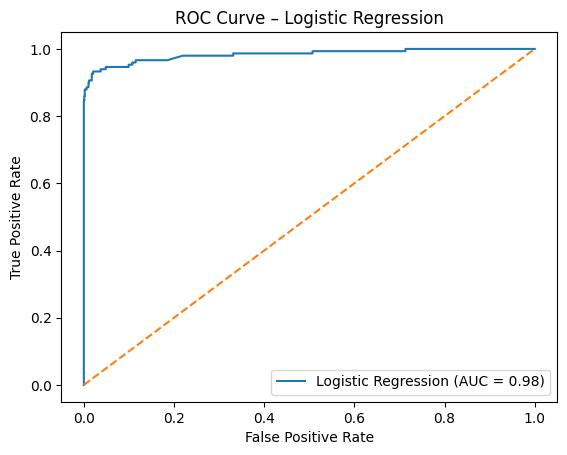

In [10]:
# ROC Curve & AUC

# TF-IDF Vectorization
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

print("\nROC AUC score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

ROC AUC = 0.98

This means:  
The model ranks spam higher than ham 98% of the time

It is useful for binary classification tasks.  
The AUC value represents the probability that the model will rank a randomly chosen positive example higher than a randomly chosen negative example.

In [11]:
# Cross-Validation
cv_scores = cross_val_score(
    log_reg_model,
    X_train_tfidf,
    y_train,
    scoring="f1",
    cv=5
)

print("Cross-validated F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

Cross-validated F1 scores: [0.93004115 0.93670886 0.95762712 0.90909091 0.90376569]
Mean CV F1: 0.927446746226883


Mean CV F1 = 0.93

Confirms performance is not due to lucky split

In [12]:
thresholds = np.linspace(0.1, 0.9, 9)
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    print(f"Threshold {t:.1f} | Recall:", recall_score(y_test, preds))

Threshold 0.1 | Recall: 0.9865771812080537
Threshold 0.2 | Recall: 0.9664429530201343
Threshold 0.3 | Recall: 0.9463087248322147
Threshold 0.4 | Recall: 0.9328859060402684
Threshold 0.5 | Recall: 0.9060402684563759
Threshold 0.6 | Recall: 0.8791946308724832
Threshold 0.7 | Recall: 0.8590604026845637
Threshold 0.8 | Recall: 0.8187919463087249
Threshold 0.9 | Recall: 0.610738255033557


The Logistic Regression model does not directly predict:  
“spam” or “ham”  
Instead, it predicts a probability with a Default threshold = 0.5

Threshold analysis answers the question:  
“What happens if I move the decision boundary?”  

| Threshold | Recall |
| --------- | ------ |
| 0.1       | 0.99   |
| 0.5       | 0.91   |
| 0.9       | 0.61   |

**Low threshold (0.1)**  
“If the model is even slightly suspicious, mark as spam.”

**Default threshold (0.5)**  
“Only mark as spam if the model is reasonably confident.”

**High threshold (0.9)**  
“Only mark as spam if the model is extremely confident.”  


SO:  
- Lower threshold = higher recall = more spam caught
- Higher threshold = fewer false positives = more spam missed

## Logistic Regression Evaluation

Logistic Regression performs very well on this task, achieving high precision and recall for spam detection despite class imbalance.  
The model generalizes well, with only a small gap between training and test F1-scores and stable cross-validation results.  
A high ROC AUC score shows strong separability between spam and ham emails, indicating that a linear decision boundary in TF-IDF space is sufficient for this problem. 

In [ ]:
# Hyperparameter Tuning
# Trying different values of C for Logistic Regression
C_values = [0.01, 0.1, 1, 10, 100] # This controls the regularization strength (lower C = stronger regularization = simpler model / Higher C = weaker regularization = more complex model)
results = []

for C in C_values:
    model = LogisticRegression(
        C=C,
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    )
    model.fit(X_train_tfidf, y_train)

    train_f1 = f1_score(y_train, model.predict(X_train_tfidf))
    test_f1 = f1_score(y_test, model.predict(X_test_tfidf))

    results.append({
        "C": C,
        "Train F1": train_f1,
        "Test F1": test_f1
    })

pd.DataFrame(results)

,C,Train F1,Test F1
0,0.01,0.908938,0.895623
1,0.10,0.927973,0.886667
2,1.00,0.965461,0.912162
3,10.00,0.983471,0.906040
4,100.00,0.993322,0.915825


## Bias–Variance Trade-off

This explicitly shows how changing hyperparameters affects underfitting vs overfitting.

- Small C values → strong regularization → underfitting (high bias)
- Large C values → complex model → risk of overfitting (high variance)
- Best performance occurs where train and test scores are balanced

**Low C (0.01, 0.1) = Underfitting**  
Model is too simple. This indicates high bias.  

**Medium C (1) = Best balance**  
Best generalization. This is the optimal bias–variance trade-off.  

**High C (10, 100) = Overfitting tendencies**  
Gap between train and test widens. This indicates higher variance.  

The regularization parameter C shows the bias–variance trade-off in Logistic Regression.  
Low C values lead to underfitting due to strong regularization, while higher C values increase model complexity and training performance.  
The best generalization is achieved at moderate C values, where training and test F1-scores are both high and closely aligned, indicating a balanced trade-off between bias and variance.

(More examples of overfitting and underfitting are at the end of the notebook)

---
# Random Forest Classifier
---

In [30]:
# Random Forest Classifier (Alternative Model)
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train_tfidf, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_tfidf)
rf_proba = rf_model.predict_proba(X_test_tfidf)[:, 1]  # probabilities for ROC

print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, rf_pred))

print("\nTrain F1:", f1_score(y_train, rf_model.predict(X_train_tfidf)))
print("\nTest F1:", f1_score(y_test, rf_model.predict(X_test_tfidf)))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.84      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[966   0]
 [ 24 125]]

Accuracy:
0.97847533632287

Train F1: 0.9974853310980721

Test F1: 0.9124087591240876



ROC AUC score: 0.9852467102977754


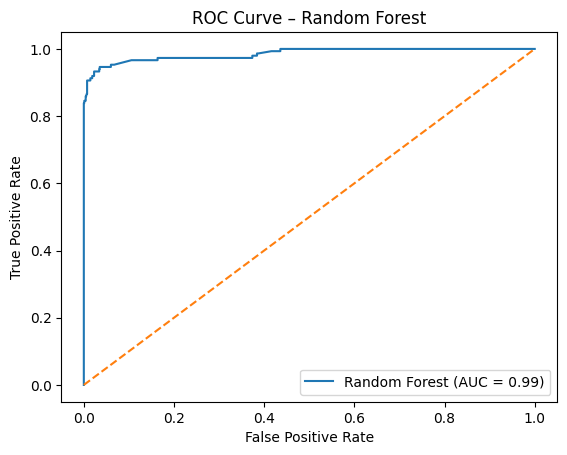

In [15]:
# ROC Curve & AUC

# TF-IDF Vectorization
fpr, tpr, thresholds = roc_curve(y_test, rf_proba)
roc_auc = roc_auc_score(y_test, rf_proba)

print("\nROC AUC score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Random Forest")
plt.legend()
plt.show()

In [16]:
# Cross-Validation
cv_scores = cross_val_score(
    rf_model,
    X_train_tfidf,
    y_train,
    scoring="f1",
    cv=5
)

print("Cross-validated F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

Cross-validated F1 scores: [0.92640693 0.92640693 0.9339207  0.92792793 0.92511013]
Mean CV F1: 0.9279545235492371


In [17]:
thresholds = np.linspace(0.1, 0.9, 9)
for t in thresholds:
    preds = (rf_proba >= t).astype(int)
    print(f"Threshold {t:.1f} | Recall:", recall_score(y_test, preds))

Threshold 0.1 | Recall: 0.9664429530201343
Threshold 0.2 | Recall: 0.9463087248322147
Threshold 0.3 | Recall: 0.912751677852349
Threshold 0.4 | Recall: 0.8926174496644296
Threshold 0.5 | Recall: 0.8389261744966443
Threshold 0.6 | Recall: 0.7919463087248322
Threshold 0.7 | Recall: 0.7248322147651006
Threshold 0.8 | Recall: 0.6912751677852349
Threshold 0.9 | Recall: 0.5234899328859061


## Random Forest Evaluation (Bagging)

The Random Forest model achieves very high precision for spam detection while showing slightly lower recall compared to Logistic Regression.  
This indicates a more conservative behavior, where false positives are minimized at the cost of missing some spam emails.  
The near-perfect training F1-score combined with a lower test F1-score suggests mild overfitting, although cross-validation results show stable generalization.  
A high ROC AUC score confirms strong class separability, and threshold analysis demonstrates that recall can be increased by lowering the decision threshold, allowing the model’s behavior to be adjusted based on application needs.  

---
# Gradient Boosting Classifier
---

In [31]:
# Gradient Boosting Classifier (Alternative Model)
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_tfidf.toarray(), y_train)

# Predictions
gb_pred = gb_model.predict(X_test_tfidf.toarray())
gb_proba = gb_model.predict_proba(X_test_tfidf)[:, 1]  # probabilities for ROC

print("\nClassification Report:")
print(classification_report(y_test, gb_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, gb_pred))

print("\nAccuracy:")
print(accuracy_score(y_test, gb_pred))

print("\nTrain F1:", f1_score(y_train, gb_model.predict(X_train_tfidf.toarray())))
print("\nTest F1:", f1_score(y_test, gb_model.predict(X_test_tfidf.toarray())))


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.97      0.74      0.84       149

    accuracy                           0.96      1115
   macro avg       0.97      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115


Confusion Matrix:
[[963   3]
 [ 38 111]]

Accuracy:
0.9632286995515695

Train F1: 0.9118982742960945

Test F1: 0.844106463878327



ROC AUC score: 0.9656439757110898


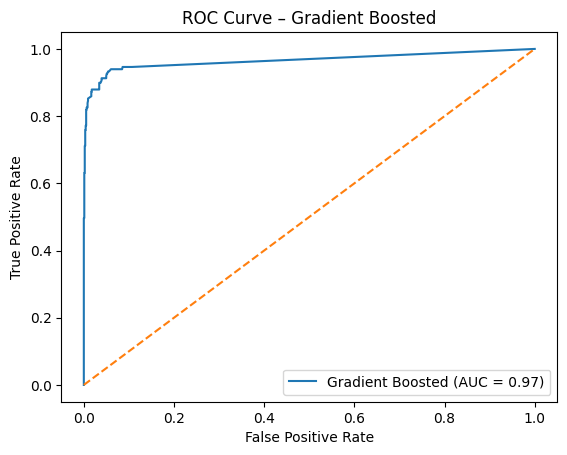

In [19]:
# ROC Curve & AUC

# TF-IDF Vectorization
fpr, tpr, thresholds = roc_curve(y_test, gb_proba)
roc_auc = roc_auc_score(y_test, gb_proba)

print("\nROC AUC score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Gradient Boosted (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Gradient Boosted")
plt.legend()
plt.show()

In [20]:
# Cross-Validation
cv_scores = cross_val_score(
    gb_model,
    X_train_tfidf,
    y_train,
    scoring="f1",
    cv=5
)

print("Cross-validated F1 scores:", cv_scores)
print("Mean CV F1:", cv_scores.mean())

Cross-validated F1 scores: [0.83412322 0.84210526 0.85308057 0.81773399 0.8097561 ]
Mean CV F1: 0.8313598284671697


In [21]:
thresholds = np.linspace(0.1, 0.9, 9)
for t in thresholds:
    preds = (gb_proba >= t).astype(int)
    print(f"Threshold {t:.1f} | Recall:", recall_score(y_test, preds))

Threshold 0.1 | Recall: 0.8993288590604027
Threshold 0.2 | Recall: 0.8523489932885906
Threshold 0.3 | Recall: 0.8187919463087249
Threshold 0.4 | Recall: 0.785234899328859
Threshold 0.5 | Recall: 0.7449664429530202
Threshold 0.6 | Recall: 0.6241610738255033
Threshold 0.7 | Recall: 0.5503355704697986
Threshold 0.8 | Recall: 0.436241610738255
Threshold 0.9 | Recall: 0.3288590604026846


## Gradient Boosting Evaluation (Boosting)

The Gradient Boosting model achieves high precision for spam detection but noticeably lower recall compared to Logistic Regression and Random Forest.  
This indicates that while the model is effective at avoiding false positives, it misses a larger portion of spam emails.  
The gap between training and test F1-scores, along with lower cross-validated performance, suggests limited generalization in this high-dimensional text setting.  
Although the ROC AUC score remains high, threshold analysis shows a steeper decline in recall as the threshold increases, reflecting the model’s sensitivity to decision boundaries.  
Overall, Gradient Boosting is less suited for this problem than simpler linear models, likely due to the sparsity and high number of TF-IDF features.

## Bagging vs Boosting

Bagging (Random Forest):
- Trains models independently
- Reduces variance (makes it less sensative)

Boosting (Gradient Boosting):
- Trains models sequentially
- Focuses on correcting previous errors
- Often improves recall for minority class

**Bagging (Random Forest):**  
Bagging, or Bootstrap Aggregating, trains many independent models (decision trees in a Random Forest) on random subsets of the training data.  
Each tree votes equally on the final prediction. This reduces variance and makes the model more robust to overfitting.  
In our example, Random Forest achieves high precision and recall with both training and test F1-scores close together, showing it generalizes well without memorizing the training data.

#### **Simply said:** Training lots of models on different slices of data in parallel, then averaging their results. This helps to cancle out random errors.

**Boosting (Gradient Boosting):**  
Boosting trains models sequentially, where each new tree focuses on the errors of the previous ones. This allows the ensemble to learn complex decision boundaries, but it increases the risk of overfitting.  
In our example, Gradient Boosting has high training F1 but lower test F1 and lower cross-validated scores.  
This indicates that while it learns the training data very well, it generalizes less effectively on unseen data.

#### **Simply said:** Each step learns from the mistakes of the previouse mistake of the past. Training models sequentially, one after another each one focusing what the last one missed.  


| Feature                  | Random Forest (Bagging)                       | Gradient Boosting (Boosting)                          |
| ------------------------ | --------------------------------------------- | ----------------------------------------------------- |
| Training process         | Trees trained independently on random subsets | Trees trained sequentially to correct previous errors |
| Variance                 | Reduced                                       | Can be high if model overfits                         |
| Bias                     | Moderate                                      | Low (can fit complex patterns)                        |
| Generalization           | High                                          | Slightly lower on sparse text features                |
| Example from notebook    | Train F1: 0.997, Test F1: 0.912               | Train F1: 0.912, Test F1: 0.844                       |


---
# Underfitting on purpose (high bias)
---

what has changed:
- **Only 50 TF-IDF features**
- **Strong information loss** (because most spam-specific words or sentinces will be ignored due to the 50 max features)
- **Model cannot represent language patterns** (this is again because of the 50 max features making it that the model cant make patterns)

In [22]:
model_underfit = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

model_underfit.fit(X_train_underfit, y_train)

y_proba_underfit = model_underfit.predict_proba(X_test_underfit)[:, 1]  # probabilities for ROC

print(classification_report(y_test, model_underfit.predict(X_test_underfit)))

print("Train F1:", f1_score(y_train, model_underfit.predict(X_train_underfit)))
print("Test F1:", f1_score(y_test, model_underfit.predict(X_test_underfit)))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       966
           1       0.65      0.79      0.71       149

    accuracy                           0.92      1115
   macro avg       0.81      0.86      0.83      1115
weighted avg       0.92      0.92      0.92      1115

Train F1: 0.6754863813229572
Test F1: 0.7134146341463414



ROC AUC score: 0.9166492975947309


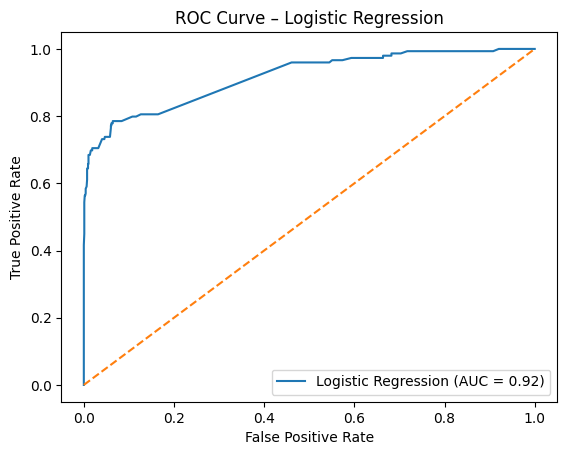

In [23]:
# TF-IDF Vectorization
fpr, tpr, thresholds = roc_curve(y_test, y_proba_underfit)
roc_auc = roc_auc_score(y_test, y_proba_underfit)

print("\nROC AUC score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

### results
- Train F1 ≈ 0.68
- Test F1 ≈ 0.71
- Low recall & precision for spam
- ROC AUC ≈ 0.92 (much lower than other models)

### why is it underfitting
- The model performs poorly on both training and test data
- There is no large gap between train and test performance
- The model has high bias

### conclusion
The model is too simple to capture the relationship between words and spam labels. (Model simplicity = limited expressive power)

### Underfitting Model Analysis

The underfitting model uses a highly restricted feature space with only 50 TF-IDF features.
This limits the model’s ability to represent meaningful patterns in the data.

Both training and test F1-scores are low and similar, indicating high bias. (Bias is the error caused by over-simplifying assumptions in a model.)  
The model is too simple to learn the underlying structure of spam and ham messages,
resulting in underfitting.


---
# Overfitting on purpose (high variance)
---

what has changed:
- **20,000 TF-IDF features** (this is high number will train the model to use noise instead of patterns)
- **Unigrams + bigrams** (allowing the model to learn very specific word combinations that may not generalize)
- **Very high regularization parameter (C = 1000)** so this assigns extreme importance to tiny patterns
- **No class balancing** (Class balancing was removed to isolate overfitting effects caused purely bymodel complexity rather than class distribution adjustments)

In [24]:
model_overfit = LogisticRegression(
    C=1000,
    max_iter=1000,
    random_state=42
)

model_overfit.fit(X_train_overfit, y_train)

y_proba_overfit = model_overfit.predict_proba(X_test_overfit)[:, 1]  # probabilities for ROC

print(classification_report(y_test, model_overfit.predict(X_test_overfit)))

print("Train F1:", f1_score(y_train, model_overfit.predict(X_train_overfit)))
print("Test F1:", f1_score(y_test, model_overfit.predict(X_test_overfit)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115

Train F1: 0.999163179916318
Test F1: 0.9513888888888888



ROC AUC score: 0.9877652257284589


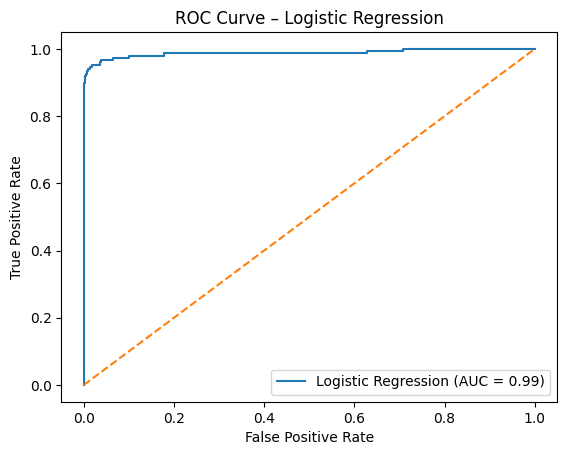

In [25]:
# TF-IDF Vectorization
fpr, tpr, thresholds = roc_curve(y_test, y_proba_overfit)
roc_auc = roc_auc_score(y_test, y_proba_overfit)

print("\nROC AUC score:", roc_auc)

plt.figure()
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.legend()
plt.show()

### results
- Train F1 ≈ 0.999
- Test F1 ≈ 0.95
- Very strong training performance
- Slight degradation on test set ( from 0.999 to 0.95 meaning it does not generalize well)
- ROC AUC ≈ 0.99

### why is it Overfitting
- The model memorizes training data extremely well
- Performance drops slightly on unseen data (Unseen data refers to the test set, which is not used during training and is used to evaluate generalization)
- High variance due to excessive model complexity (High variance is problematic because the model becomes overly sensitive to the training data) 

### conclusion
The test performance is still high, but the gap between train and test indicates overfitting tendencies.

### Overfitting Model Analysis

In a high-dimensional feature space, weak regularization allows the model to
overfit by learning noise rather than generalizable patterns.

The training F1-score is nearly perfect, while test performance is slightly lower.
This gap indicates high variance, as the model begins to memorize the training data
rather than generalizing optimally.



---
## Bias–Variance Trade-off

The underfitting model demonstrates high bias, failing to capture patterns in both  
training and test data.  

The overfitting model demonstrates high variance, achieving near-perfect performance  
on training data but slightly reduced generalization on unseen data.  

The optimal model lies between these extremes, balancing bias and variance to achieve  
strong and stable performance on new emails.  

---


“What does underfitting vs overfitting mean in my notebook?”

Underfitting occurs when the model is too simple to capture text patterns, leading to poor performance on both training and test data, while overfitting occurs when excessive feature complexity allows the model to memorize training data, reducing generalization.